# SD701 - Cover Type Prediction of Forests
## Clément P. (clemente924)
### Nov. 2017
NB: I abandoned Databricks' Spark for performance reasons, as soon as the calculations looked pretty heavy...

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.linear_model import OrthogonalMatchingPursuit, LogisticRegression
import graphviz

%matplotlib inline

## Data import

In [2]:
# Import training set
train_data = pd.read_csv('train-data.csv')

In [3]:
train_data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [4]:
train_data.shape

(15120, 56)

In [5]:
train_data.isnull().sum().sum()

0

The data set is clean...

In [6]:
train_data.groupby('Cover_Type')['Id'].count()

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Id, dtype: int64

... and the classes perfectly balanced.

In [7]:
train_data.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [8]:
# Isolate numerical variables
num_cols = train_data.columns[1:11]
num_cols.shape

(10,)

In [9]:
# Isolate categorical variables
cat_cols = train_data.columns[11:-1]
cat_cols.shape

(44,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D40E46C50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022D44165358>]], dtype=object)

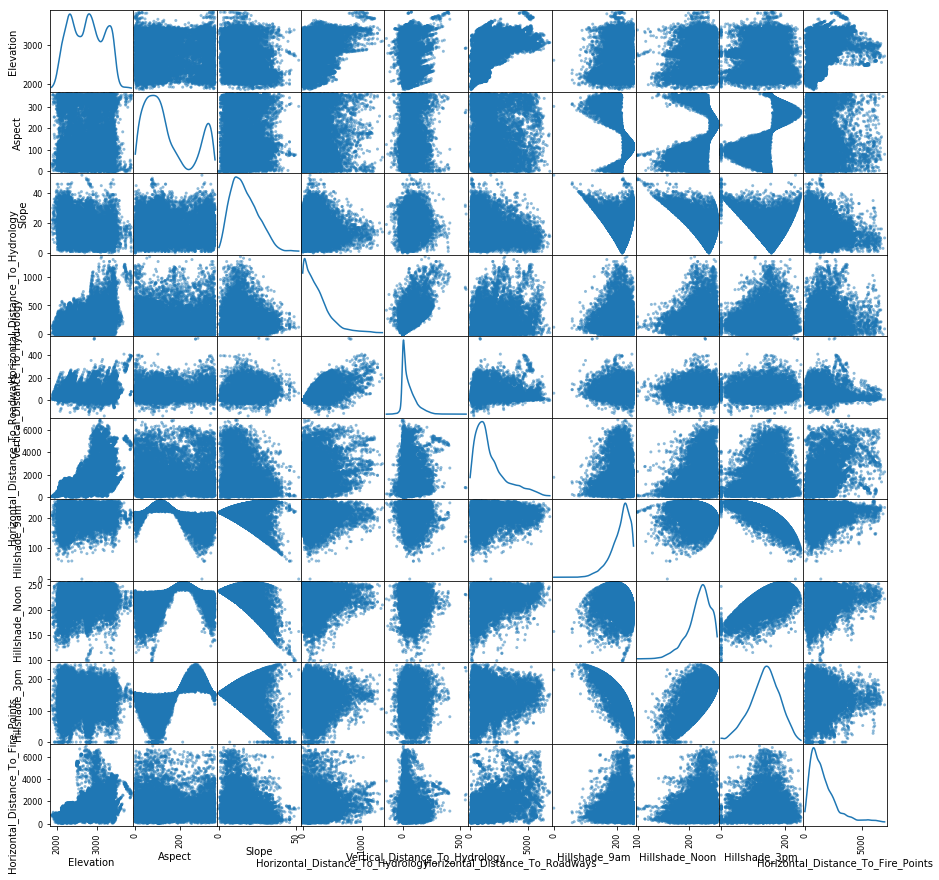

In [10]:
# Look at numerical variables
scatter_matrix(train_data[num_cols], figsize=(15, 15), diagonal='kde')

Some plots have 'nice' shapes which suggest some dependence among the variables.

In [11]:
# Import test set
test_data = pd.read_csv('test-data.csv')

In [12]:
test_data.columns == train_data.columns[:-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

Just out of curiosity, let's look at the same pair plots for the test set.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D40F65EF0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022D4A9D9C88>]], dtype=object)

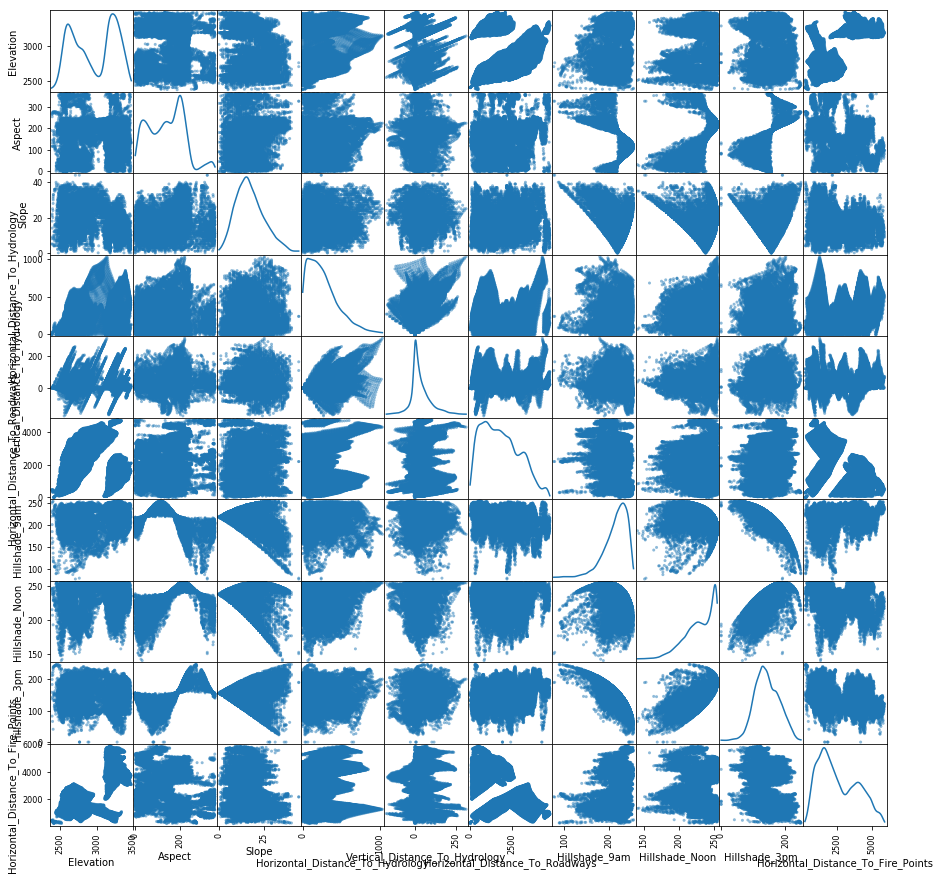

In [13]:
scatter_matrix(test_data[num_cols], figsize=(15, 15), diagonal='kde')

In [14]:
pd.concat([train_data[num_cols].mean(), test_data[num_cols].mean()], axis=1)

,0,1
Elevation,2749.322553,2966.56830
Aspect,156.676653,144.77595
Slope,16.501587,16.93475
Horizontal_Distance_To_Hydrology,227.195701,255.49665
Vertical_Distance_To_Hydrology,51.076521,31.92645
Horizontal_Distance_To_Roadways,1714.023214,1904.48780
Hillshade_9am,212.704299,215.04040
Hillshade_Noon,218.965608,229.54470
Hillshade_3pm,135.091997,142.39710
Horizontal_Distance_To_Fire_Points,1511.147288,2595.92550


We now build the features matrix and the labels vector.

In [15]:
cols_to_remove = ['Id']
# One dummy variable of each type needs to be dropped
cols_to_remove += ['Soil_Type1', 'Wilderness_Area1']

Some categorical variables are zero on all instances and need to be dropped:

In [16]:
pd.concat([train_data[cat_cols].sum(axis=0), test_data[cat_cols].sum(axis=0)], axis=1)

,0,1
Wilderness_Area1,3597,0
Wilderness_Area2,499,8199
Wilderness_Area3,6349,11801
Wilderness_Area4,4675,0
Soil_Type1,355,0
Soil_Type2,623,673
Soil_Type3,962,1021
Soil_Type4,843,174
Soil_Type5,165,0
Soil_Type6,650,0


In [17]:
drop_zero_cols = True
threshold = 0.1
c = train_data.sum(axis=0) < threshold
if drop_zero_cols:
    cols_to_remove += c.index[c].tolist()
cols_to_remove

['Id', 'Soil_Type1', 'Wilderness_Area1', 'Soil_Type7', 'Soil_Type15']

The 'threshold' parameter controls the number of poorly represented variables that will be dropped from the original training set. I increased it to 50 with no improvement on the Kaggle score.

In [18]:
X_train = train_data.drop(['Cover_Type'] + cols_to_remove, axis=1)
y_train = train_data['Cover_Type']
X_test = test_data.drop(cols_to_remove, axis=1)

## Analysis

### Scaling

I tested different scaling strategies:
- no scaling
- standard scaling
- min-max scaling
- standard scaling - numerical variables only

No scaling proved to be the better choice.

In [19]:
# Scale
scale1 = False
scaler = MinMaxScaler().fit(X_train)
#scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns) if scale1 else X_train
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) if scale1 else X_test

In [20]:
# Scale
scale2 = False
if scale2:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    scaler = StandardScaler().fit(X_train[num_cols])
    X_train_scaled[colToScale] = scaler.transform(X_train[num_cols])
    X_test_scaled[colToScale] = scaler.transform(X_test[num_cols])

### Dimensionality reduction

I thought it could be good to reduce the dimensionality of the training set before fitting any model - keeping only the most significant variables. I tried out two things:
- Principal Component Analysis (PCA)
- Orthogonal Matching Pursuit (OMP)

Unfortunately, this did not yield any improvement.

In [21]:
#pca = PCA(n_components=0.95, svd_solver='full')
#X_train_scaled = pca.fit_transform(X_train_scaled)
#X_test_scaled = pca.fit_transform(X_test_scaled)

In [22]:
# OMP
max_n_nonzero_coefs = 15  # first start with X_train_scaled.shape[1], then reduce
n_nonzero_coefs_grid = np.arange(1, max_n_nonzero_coefs + 1)
param_grid = dict(n_nonzero_coefs=n_nonzero_coefs_grid)
gs = GridSearchCV(OrthogonalMatchingPursuit(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
             normalize=True, precompute='auto', tol=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_nonzero_coefs': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

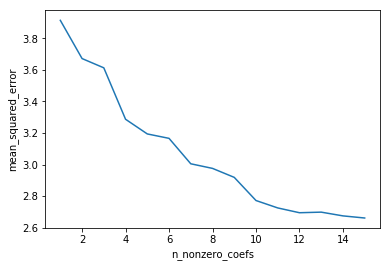

In [23]:
plt.plot(n_nonzero_coefs_grid, -gs.cv_results_['mean_test_score'])
plt.xlabel('n_nonzero_coefs')
plt.ylabel('mean_squared_error')

In [24]:
X_train_scaled.columns[gs.best_estimator_.coef_.nonzero()]

Index(['Elevation', 'Horizontal_Distance_To_Roadways', 'Wilderness_Area2',
       'Wilderness_Area3', 'Soil_Type10', 'Soil_Type12', 'Soil_Type13',
       'Soil_Type22', 'Soil_Type30', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')

In [25]:
#cols_to_remove = X_train_scaled.columns[gs.best_estimator_.coef_ == 0]
#X_train_scaled = X_train_scaled.drop(cols_to_remove, axis=1)
#X_test_scaled = X_test_scaled.drop(cols_to_remove, axis=1)

### Building a classifier

I started with some common classifiers, used in the labs:
- Logistic Regression 
- Decision Tree
- Random Forest

In [26]:
clf_lr = LogisticRegression()
clf_dt = DecisionTreeClassifier(max_depth=20)
clf_rf = RandomForestClassifier(n_estimators=300, max_features=20)

# Print the score (uses cross-validation)
print(cross_val_score(clf_lr, X_train_scaled, y_train, cv=10, scoring='accuracy').mean())
print(cross_val_score(clf_dt, X_train_scaled, y_train, cv=10, scoring='accuracy').mean())
print(cross_val_score(clf_rf, X_train_scaled, y_train, cv=10, scoring='accuracy').mean())

0.629497354497
0.711838624339
0.790013227513


In [27]:
# Visualizing the tree
#dot_data = export_graphviz(clf, out_file=None)  
#graph = graphviz.Source(dot_data)  
#graph 

As the random forest classifier was performing the best, I ran a grid search to find the optimal 'n_estimators' and 'max_features' hyperparameters, as follows. This resulted in a Kaggle score of around 60%.

In [28]:
#n_estimators_range = np.arange(50, 500, 50)
#max_features_range = np.arange(2, 22, 2)
#param_grid = dict(n_estimators=n_estimators_range, max_features=max_features_range)
#clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=StratifiedShuffleSplit(n_splits=5), scoring='accuracy', n_jobs=-1, verbose=10)

I then gave a try to Support Vector classification. I first ran LinearSVC(dual=False), then SVC(kernel='linear'), but the best test score was obtained with kernel='rbf' (default option). Each time, I used a grid search to select the good hyperparameters, i.e. C and gamma. This brought the Kaggle score to around 74%.

(C, gamma) = (10.0, 0.00001) yielded the best test score (around 87%).

NB: The results of the cross-validation are attached in a separate csv file and do not correspond to the ones below obtained with other parameters.

In [29]:
C_range = np.logspace(-2, 6, 9)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(C=C_range, gamma=gamma_range)
clf = GridSearchCV(SVC(), param_grid=param_grid, cv=StratifiedShuffleSplit(n_splits=5), scoring='accuracy', n_jobs=-1, verbose=10)

In [30]:
# Fit model
clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size='default',
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1.0], 'gamma': [0.0001]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=10)

In [31]:
clf.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [32]:
clf.best_score_

0.848015873015873

In [33]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,88.207276,2.131279,0.848016,0.9908,1,0.0001,"{'C': 1.0, 'gamma': 0.0001}",1,0.852513,0.991035,...,0.85119,0.990447,0.847884,0.991108,0.844577,0.991255,21.488873,0.222923,0.003434,0.000424


In [34]:
# Write output file
output = pd.DataFrame(columns=['Id', 'Cover_Type'])
output['Id'] = test_data['Id']
output['Cover_Type'] = clf.predict(X_test_scaled)
output.set_index('Id', drop=True, inplace=True)
output.to_csv('forest_prediction_output.csv')

In [35]:
# Distribution of predicted classes
output['Cover_Type'].value_counts()

2    13095
1     4597
6      904
3      790
5      399
7      215
Name: Cover_Type, dtype: int64

Increasing the number of folds from 5 to 10, or refining the grid for C or gamma (e.g. gamma_range = np.linspace(0.00001, 0.0001, 10)) did not make any difference.

NB: (1.0, 0.0001) gives a slightly better Kaggle score than the value of (10.0, 0.00001) found by cross-validation. I think it will not be the case anymore when the score is calculated on 100% of the test set, not just 30%.

In [36]:
# Testing purpose: create output file for some predefined (C, gamma) combinations
C_range = [1.0, 10.0]
gamma_range = [0.0001, 0.00001]
for c in C_range:
    for gamma in gamma_range:
        clf = SVC(C=c, gamma=gamma)
        clf.fit(X_train_scaled, y_train)
        # Write output
        output = pd.DataFrame(columns=['Id', 'Cover_Type'])
        output['Id'] = test_data['Id']
        output['Cover_Type'] = clf.predict(X_test_scaled)
        output.set_index('Id', drop=True, inplace=True)
        output.to_csv('forest_prediction_output_{}_{}.csv'.format(c, gamma))